# MAST Table Access Protocol Hubble Source Catalog Demo

## Table of Contents

1. [HSC TAP Service Introduction](#HSC-TAP-Service-Introduction)
2. [Imports](#Imports)
3. [Display Tweaks](#Display-Tweaks)
4. [Connecting, Finding, and Displaying Table Information](#Connecting,-Finding,-and-Displaying-Table-Information)
    - [Connecting to a TAP Service](#Connecting-to-a-TAP-Service)
    - [Querying for Table Schema Information](#Querying-for-Table-Schema-Information)
    - [Querying for Data](#Querying-for-Data)
    - [Use Case: Plotting a light curve for the most variable object in a field](#Use-Case:-Plotting-a-light-curve-for-the-most-variable-object-in-a-field)
    - [Use Case: Create a color magnitude diagram for the Small Magellanic Cloud](#Use-Case:-Create-a-color-magnitude-diagram-for-the-Small-Magellanic-Cloud) <br><br>
5. [Appendix](#Appendix)

## HSC TAP Service Introduction
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

Table Access Protocol (TAP) services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with the SQL-like Astronomical Data Query Language (ADQL), and can include geographic / spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set of coumns retunred from cone, image, and spectral services.

For this example, we'll be using the astroquery TAP/TAP+ client, which was developed by the ESAC Space Data Centre for working with the GAIA catalog, but is interoperable with other valid TAP services, including those at MAST. As an astroquery project, TAP+ documentation is available at ReadTheDocs: http://astroquery.readthedocs.io/en/latest/utils/tap.html

We'll be using TAP+ to call the most recent version (3) of the Hubble Source Catalog TAP service at MAST. The schema is described within the service, and we'll show how to inspect it. The schema is also the same as the one available via the CasJobs interface, with an additional view added for the most common positional queries. CasJobs has its own copy of the schema documentation, which can be accessed through its own site: http://mastweb.stsci.edu/hcasjobs/



## Imports
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

In [1]:
# Use the astroquery TapPlus library.
from astroquery.utils.tap.core import TapPlus

## For handling ordinary astropy Tables in responses
from astropy.table import Table, vstack

## For reading FITS files once we locate them via TAP
import astropy.io.fits as apfits

# For displaying and manipulating some types of results
%matplotlib inline
import requests, io, astropy, numpy, pylab, time

# To allow display tweaks for wider response tables
from IPython.core.display import display, HTML

# For the second example: kernel density estimates
from scipy.stats import gaussian_kde

## Display Tweaks
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

In [2]:
# Set page width to fill browser for longer output lines
display(HTML("<style>.container { width:100% !important; }</style>"))

# set width for pprint
astropy.conf.max_width = 150

## Connecting, Finding, and Displaying Table Information 
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

### Connecting to a TAP Service
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

The TapPlus library is able to connect to any TAP service, given the "base" URL as noted in metadata registry resources describing the service. This is the URL for the newest version of the Hubble Source Catalog TAP service.

In [3]:
HSC_service = TapPlus(url="http://vao.stsci.edu/HSCTAP/tapservice.aspx")

Created TAP+ (v1.0.1) - Connection:
	Host: vao.stsci.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### Querying for Table Schema Information
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>
    
TAP services are self-describing, which means the service itself can be asked for its schema and documentation about it. Since the hubble Source Catalog does not follow a data model described by a standard, this is the best way to see what tables and columns we have available to then query based on geometry or other filters. 
    
The main view for HSC, SumMagAper2CatView, is extremely wide, containing columns for all potential filters, each of which may have null data. So in showing our query results, we will cut off the display with "..." marks. You can change the 'if' line to show the rest of these columns.

In [4]:
HSC_tables = HSC_service.load_tables()
print('\n')
for table in HSC_tables:
    if( table.get_name() == 'dbo.SumMagAper2CatView'):
        print(table)
        print('\n')
        columns = table.get_columns()
        for i, column in enumerate(columns):
            #only show the first 30 and last 10 columns
            if i < 30 or i > len(columns)-10:
                print(column.get_name())
            #skip display for the middle column names
            elif i == 30:
                print("...")

Retrieving tables...
Parsing tables...
Done.


TAP Table name: dbo.dbo.SumMagAper2CatView
Description: This table provides Source Extractor magaper2 information for each match based on sources with valid Source Extractor aper2 magnitudes. The companion table SumMagAper2CatViewView  contains other summary information for the corresponding match
Num. columns: 818


MatchID
MatchRA
MatchDec
DSigma
AbsCorr
NumFilters
NumVisits
NumImages
StartTime
StopTime
StartMJD
StopMJD
TargetName
CI
CI_Sigma
KronRadius
KronRadius_Sigma
Extinction
SpectrumFlag
MatchID
W3_BLANK
W3_BLANK_MAD
W3_BLANK_N
W2_F122M
W2_F122M_MAD
W2_F122M_N
W2_F160BN15
W2_F160BN15_MAD
W2_F160BN15_N
W2_F160BW
...
W3_F160W
W3_F160W_MAD
W3_F160W_N
W3_F164N
W3_F164N_MAD
W3_F164N_N
W3_F167N
W3_F167N_MAD
W3_F167N_N


### Querying for Data
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

As noted above, this view contains every filter known in the HSC, and can return each even if it is NULL for the given match (this can cause warnings in astroquery). In order to narrow results, one could query on individual filters where their value is not null, or only return certain of them. 

Here we are searching for every row with data within a .1 degree circle of RA=129.23 and Dec=7.95, and returning a few columns to get an idea of what we have available.

In [5]:
job = HSC_service.launch_job("""
SELECT TOP 10 MatchRA, MatchDec, TargetName, StartTime, StopTime
FROM dbo.SumMagAper2CatView
WHERE CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  """)
HSC_results = job.get_results()
HSC_results.pprint()

Launched query: '
SELECT TOP 10 MatchRA, MatchDec, TargetName, StartTime, StopTime
FROM dbo.SumMagAper2CatView
WHERE CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  '
Retrieving sync. results...
Query finished.
     MatchRA            MatchDec        TargetName        StartTime             StopTime      
------------------ ------------------ -------------- -------------------- --------------------
129.21722965780199 7.9454347042557503 J083655+075712 12/7/2009 4:10:34 PM 12/7/2009 4:53:36 PM
129.21773771456199 7.9541410296550801 J083655+075712 12/7/2009 4:10:34 PM 12/7/2009 4:53:36 PM
129.21822639525701 8.0414840316751395 SDSSJ0837+0801 3/15/2015 2:34:37 PM 3/15/2015 3:07:16 PM
129.20779915939201 7.9492882332152996 J083655+075712 12/7/2009 4:10:34 PM 12/7/2009 4:53:36 PM
  129.233483726636 8.0433272739475097 SDSSJ0837+0801 3/15/2015 2:34:37 PM 3/15/2015 3:07:16 PM
  129.257510357765 8.0281886081882696 SDSSJ0837+0801 3/15/2015 2:22:48 PM 3/15/2015 3:07:16 PM

We can also filter by start/stop time or any other column in the view:

In [6]:
job = HSC_service.launch_job("""
SELECT TOP 10 MatchID, MatchRA, MatchDec, TargetName, StartTime, StopTime, TargetName 
FROM dbo.SumMagAper2CatView
WHERE 
CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
AND StartTime > '2015-01-01' AND StopTime < '2015-04-01'
""")
HSC_results = job.get_results()
HSC_results.pprint()

Launched query: '
SELECT TOP 10 MatchID, MatchRA, MatchDec, TargetName, StartTime, StopTime, TargetName 
FROM dbo.SumMagAper2CatView
WHERE 
CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
AND StartTime > '2015-01-01' AND StopTime < '2015-04-01'
'
Retrieving sync. results...
Query finished.
MatchID       MatchRA            MatchDec        TargetName        StartTime             StopTime        TargetName1  
-------- ------------------ ------------------ -------------- -------------------- -------------------- --------------
62536502 129.25097235585099 7.9984646612999297 SDSSJ0837+0801 3/15/2015 2:22:48 PM 3/15/2015 3:07:16 PM SDSSJ0837+0801
63998279   129.219472431442 8.0476513453222793 SDSSJ0837+0801 3/15/2015 2:22:48 PM 3/15/2015 3:07:16 PM SDSSJ0837+0801
16245848   129.251719817549 8.0290393096313402 SDSSJ0837+0801 3/15/2015 2:34:37 PM 3/15/2015 3:07:16 PM SDSSJ0837+0801
90208332    129.23932170697 8.0062708690382394 SDSSJ0837+0801 3/15/2015 2:22:48 PM 3/1

### Use Case: Plotting a light curve for the most variable object in a field
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

A use case example: search for objects with 10 or more ACS F475W magnitudes in a crowded field near IC 1613 (see <a href="http://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html">HSC Use Case 3</a>). Then get the individual A_F475W measurements for the most variable object in the list and plot the light curve. Note we are using asynchronous query mode for this example rather than synchronous, because it has a longer allowed timeout, which can be useful for large or complex queries.

Launched query: '
SELECT MatchID, MatchRA, MatchDec, TargetName, NumImages, NumVisits, A_F475W, A_F475W_MAD, A_F475W_N
FROM dbo.SumMagAper2CatView
WHERE 
   A_F475W_N >= 10
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',16.117562,2.162183,0.1))=1
   '
Retrieving async. results...
Query finished.
 MatchID       MatchRA            MatchDec      TargetName NumImages NumVisits      A_F475W            A_F475W_MAD      A_F475W_N
--------- ------------------ ------------------ ---------- --------- --------- ------------------ --------------------- ---------
 43465574 16.138859727655301 2.1782941393715398     IC1613        24        12 25.658300399780298    0.0183000564575195        12
 22043499     16.10049191877 2.1731745652341701     IC1613        26        14 25.140349388122601  0.020799636840820299        12
107404986 16.101051747364099 2.1270102255091201     IC1613        24        12   26.1569004058838  0.036399841308593799        12
  8648250   16.1129629141242   2.1

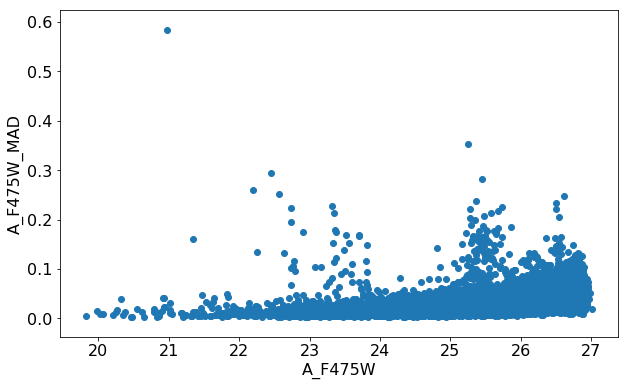

In [7]:
job = HSC_service.launch_job_async("""
SELECT MatchID, MatchRA, MatchDec, TargetName, NumImages, NumVisits, A_F475W, A_F475W_MAD, A_F475W_N
FROM dbo.SumMagAper2CatView
WHERE 
   A_F475W_N >= 10
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',16.117562,2.162183,0.1))=1
   """)
HSC_results = job.get_results()
HSC_results.pprint()

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,6))
pylab.scatter(HSC_results['A_F475W'], HSC_results['A_F475W_MAD'])
pylab.xlabel('A_F475W')
pylab.ylabel('A_F475W_MAD')


 MatchID       MatchRA            MatchDec      TargetName NumImages NumVisits      A_F475W           A_F475W_MAD     A_F475W_N
--------- ------------------ ------------------ ---------- --------- --------- ------------------ ------------------- ---------
102334412 16.130003898898298 2.1655152822114401     IC1613        26        14 20.970849990844702 0.58440017700195301        12
Launched query: '
SELECT SourceID, ImageID, SourceRA, SourceDec, D, Filter, Detector, MagAper2, StartMJD
FROM dbo.DetailedCatalog
WHERE 
   MatchID=102334412
   AND Detector='ACS/WFC' AND Filter='F475W' AND Det='Y'
ORDER BY StartMJD
'
Retrieving async. results...
Query finished.
   SourceID   ImageID      SourceRA          SourceDec               D          Filter Detector      MagAper2           StartMJD     
------------- ------- ------------------ ------------------ ------------------- ------ -------- ------------------ ------------------
4000999067867   69735   16.1300039661166 2.1655155723933301    1.07

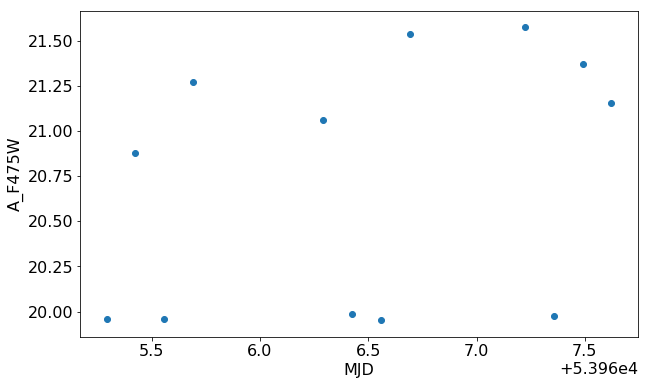

In [8]:
madvalues = HSC_results['A_F475W_MAD']
i = numpy.argmax(madvalues)
print()
print(HSC_results[i])

matchid = HSC_results['MatchID'][i]
job = HSC_service.launch_job_async("""
SELECT SourceID, ImageID, SourceRA, SourceDec, D, Filter, Detector, MagAper2, StartMJD
FROM dbo.DetailedCatalog
WHERE 
   MatchID={}
   AND Detector='ACS/WFC' AND Filter='F475W' AND Det='Y'
ORDER BY StartMJD
""".format(matchid))
HSC_details = job.get_results()
# HSC_details.sort('StartMJD')
HSC_details.pprint()

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,6))
pylab.scatter(HSC_details['StartMJD'], HSC_details['MagAper2'])
pylab.xlabel('MJD')
pylab.ylabel('A_F475W')

### Use Case: Create a color magnitude diagram for the Small Magellanic Cloud
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

For another example of using data from a TAP service, we start by doing a search around the SMC with a .25 degree radius for objects with ACS F555W and F814W measurements. HSC TAP will limit us to 100k responses by default. Note this is a large query that can take over a minute to run. See <a href="http://archive.stsci.edu/hst/hsc/help/use_case_2_v3.html" target="_blank">HSC Use Case 2</a> for more details.

In [9]:
t0 = time.time()

job = HSC_service.launch_job_async("""
SELECT MatchID, MatchRA, MatchDec, CI, A_F555W, A_F814W
FROM dbo.SumMagAper2CatView
WHERE A_F555W_N > 0 and A_F814W_N > 0
    AND CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',13.1866,-72.8286,0.25))=1
   """)
HSC_results = job.get_results()
print("Query completed in {:.1f} sec".format(time.time()-t0))
HSC_results.pprint()

Launched query: '
SELECT MatchID, MatchRA, MatchDec, CI, A_F555W, A_F814W
FROM dbo.SumMagAper2CatView
WHERE A_F555W_N > 0 and A_F814W_N > 0
    AND CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',13.1866,-72.8286,0.25))=1
   '
Retrieving async. results...
Query finished.
Query completed in 38.4 sec
 MatchID       MatchRA             MatchDec               CI              A_F555W            A_F814W      
--------- ------------------ ------------------- ------------------- ------------------ ------------------
  3570818   12.9019063354779 -72.973086476853595  1.0641049087783401 23.352100372314499 23.262599945068398
 41550198   13.9352397190841 -72.845578690976794  1.0187963092768599 21.075000762939499   21.4692993164063
 66303526   12.5216676298213   -72.8731682610576  1.6033796800507401 22.915300369262699 23.174900054931602
 45552828 13.017661849673599 -72.976577212021198  1.2726234433091701 24.620500564575199 24.321599960327099
  9343196 12.975857993409299 -72.960956793858202  

Next, plot the color-magnitude diagram for the ~100k points retrieved from the database. This uses kernel density estimate for the crowded plot, which can take a few minutes to complete.

In [10]:
f555w = HSC_results['A_F555W']
f814w = HSC_results['A_F814W']
VminusI = f555w-f814w
CI = HSC_results['CI']
w = numpy.where((CI>0.9) & (CI<1.6) & (VminusI > -1.5) & (VminusI < 1.5))
print(len(w[0]),"points remaining after CI and V-I filtering")

# Calculate the point density
x = numpy.array(VminusI[w])
y = numpy.array(f555w[w])
xy = numpy.vstack([x,y])

t0 = time.time()
z = gaussian_kde(xy)(xy)
print("kde took {:.1f} sec".format(time.time()-t0))

88239 points remaining after CI and V-I filtering
kde took 694.9 sec


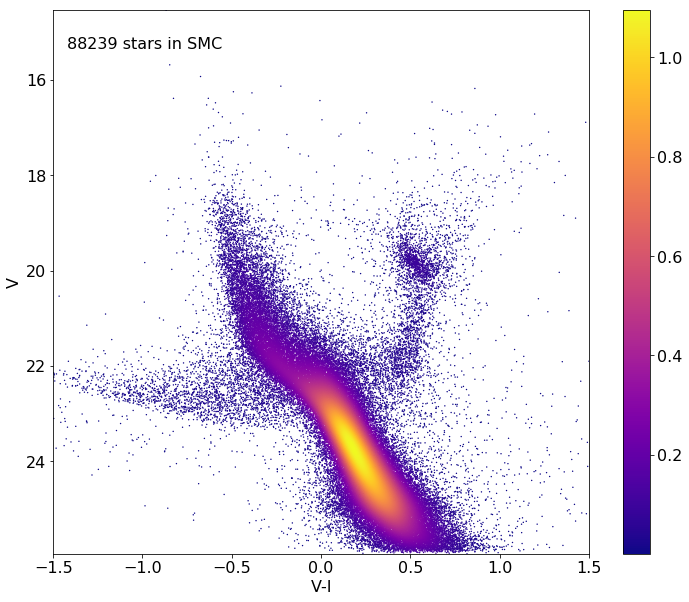

In [11]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.scatter(x, y, c=z, s=2, edgecolor='', cmap='plasma')
pylab.autoscale(tight=True)
pylab.xlabel('V-I')
pylab.ylabel('V')
pylab.gca().invert_yaxis()
pylab.colorbar()
pylab.text(.17,.93,'{:d} stars in SMC'.format(len(x)),
       horizontalalignment='center',
       transform=pylab.gca().transAxes)
pylab.savefig("smc_colormag.png")

# Appendix
<div style="text-align: right">[(top)](#MAST-TAP-Hubble-Source-Catalog-Demo)</div>

## Documentation on the Standards


### Table Access Protocol 
* IVOA standard for RESTful web service access to tabular data
* http://www.ivoa.net/documents/TAP/

### Hubble Source Catalog v3
* Catalog created at MAST by combining the tens of thousands of visit-based source lists in the Hubble Legacy Archive (HLA) into a single master catalog. 
* https://archive.stsci.edu/hst/hsc/

### Astronomical Query Data Language (2.0)
* IVOA standard for querying astronomical data in tabular format, with geometric search support
* http://www.ivoa.net/documents/latest/ADQL.html

### TapPlus 
* Module created by ESAC Space Data Centre
* http://astroquery.readthedocs.io/en/latest/utils/tap.html